## Импорт необходимых библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

## Загрузка и первичный осмотр данных

In [4]:
df = pd.read_csv('irish_rent_full.csv')

## Описание столбцов:

- rent_euro = средняя арендная плата в Евро.
- year = год наблюдения.
- half = полугодие: 
1 = первое полугодие (январь–июнь) 
2 = второе полугодие (июль–декабрь
- half_year = текстовое обозначение полугодия и года.
- time_period = порядковый номер периода (полугодия) от начала наблюдений (1 = 2020H1, 2 = 2020H2, ..., 11 = 2025H1).
- county = графство Ирландии.
- province = провинция Ирландии.
- area = административный или географический район.
- location = конкретное населённое место.
- property_type = тип недвижимости.
- bedrooms = описание количества спален.
- bedrooms_num = числовое представление количества спален.
- is_dublin =  бинарный признак: True, если запись относится к графству Дублин, иначе False.
- is_city = бинарный признак: True, если location соответствует крупному городу, иначе False.
- is_county_aggregate = бинарный признак: True, если строка представляет усреднённые данные по всему графству.- 

In [6]:
df.head()

,rent_euro,year,half,half_year,time_period,county,province,area,location,property_type,bedrooms,bedrooms_num,is_dublin,is_city,is_county_aggregate
0,835.90,2020,1,2020H1,1,Carlow,Leinster,Carlow,Carlow,All property types,All bedrooms,NaN,False,False,True
1,860.74,2020,1,2020H1,1,Carlow,Leinster,Carlow Town,Carlow Town,All property types,All bedrooms,NaN,False,False,False
2,910.91,2020,1,2020H1,1,Carlow,Leinster,Graiguecullen,"Graiguecullen, Carlow",All property types,All bedrooms,NaN,False,False,False
3,812.14,2020,1,2020H1,1,Carlow,Leinster,Tullow,"Tullow, Carlow",All property types,All bedrooms,NaN,False,False,False
4,666.31,2020,1,2020H1,1,Cavan,Ulster,Cavan,Cavan,All property types,All bedrooms,NaN,False,False,True


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50208 entries, 0 to 50207
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rent_euro            50208 non-null  float64
 1   year                 50208 non-null  int64  
 2   half                 50208 non-null  int64  
 3   half_year            50208 non-null  object 
 4   time_period          50208 non-null  int64  
 5   county               50208 non-null  object 
 6   province             50208 non-null  object 
 7   area                 50208 non-null  object 
 8   location             50208 non-null  object 
 9   property_type        50208 non-null  object 
 10  bedrooms             50208 non-null  object 
 11  bedrooms_num         37869 non-null  float64
 12  is_dublin            50208 non-null  bool   
 13  is_city              50208 non-null  bool   
 14  is_county_aggregate  50208 non-null  bool   
dtypes: bool(3), float64(2), int64(3), ob

In [8]:
df.describe()

,rent_euro,year,half,time_period,bedrooms_num
count,50208.000000,50208.000000,50208.000000,50208.000000,37869.000000
mean,1306.508984,2021.950506,1.479366,5.380378,2.123901
std,528.333082,1.559695,0.499579,3.105849,0.782008
min,401.580000,2020.000000,1.000000,1.000000,1.000000
25%,888.455000,2021.000000,1.000000,3.000000,1.500000
50%,1200.435000,2022.000000,1.000000,5.000000,2.000000
75%,1649.057500,2023.000000,2.000000,8.000000,2.000000
max,5372.870000,2025.000000,2.000000,11.000000,4.000000


## Обработка пропусков и категориальных признаков

In [10]:
# Преобразование ключевых столбцов в числовой формат
numeric_cols = ['rent_euro', 'year', 'half', 'time_period', 'bedrooms_num']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [11]:
# Преобразование булевых столбцов
bool_cols = ['is_dublin', 'is_city', 'is_county_aggregate']
for col in bool_cols:
    df[col] = df[col].map({'True': True, 'False': False})

In [12]:

# Удаление избыточных текстовых полей
df = df.drop(columns=['area', 'location', 'half_year'])

In [13]:
# Удаление строк без информации об аренде
df = df.dropna(subset=['rent_euro'])

In [14]:
df.shape

(50208, 12)

Text(0, 0.5, 'Частота')

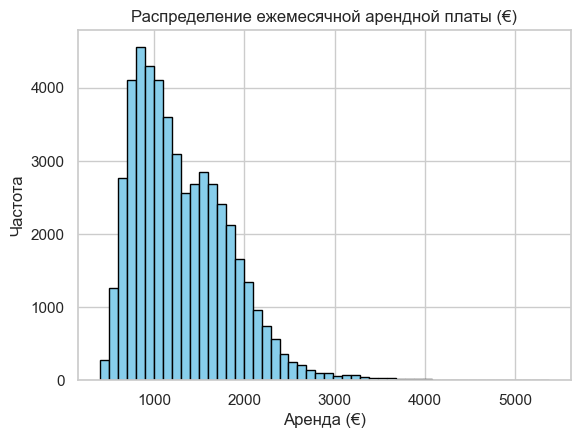

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# Распределение арендной платы
plt.subplot(2, 2, 1)
plt.hist(df['rent_euro'], bins=50, color='skyblue', edgecolor='black')
plt.title('Распределение ежемесячной арендной платы (€)')
plt.xlabel('Аренда (€)')
plt.ylabel('Частота')


Text(0, 0.5, 'Медианная аренда (€)')

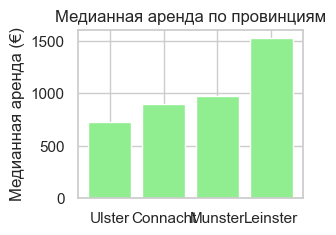

In [16]:
# Медианная аренда по провинциям
plt.subplot(2, 2, 3)
province_med = df.groupby('province')['rent_euro'].median().sort_values()
plt.bar(province_med.index, province_med.values, color='lightgreen')
plt.title('Медианная аренда по провинциям')
plt.ylabel('Медианная аренда (€)')

Text(0.5, 0, 'Медианная аренда (€)')

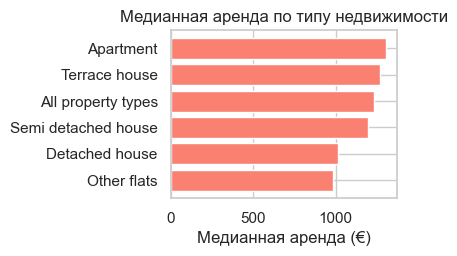

In [17]:
# Медианная аренда по типу недвижимости
plt.subplot(2, 2, 4)
prop_med = df.groupby('property_type')['rent_euro'].median().sort_values()
plt.barh(prop_med.index, prop_med.values, color='salmon')
plt.title('Медианная аренда по типу недвижимости')
plt.xlabel('Медианная аренда (€)')


## Создание и упрощение признаков

In [19]:
# Группировка редких графств в категорию "Другие"
top_counties = df['county'].value_counts().head(8).index
df['county_grouped'] = df['county'].where(df['county'].isin(top_counties), 'Other')

In [20]:
# Упрощение количества спален
df['bedrooms_simple'] = df['bedrooms'].replace({
    'All bedrooms': 'Unknown',
    '1 to 3 bed': '1-3 beds'
})


In [21]:
# Используем только ключевые признаки
features = [
    'year', 'half', 'bedrooms_num',
    'is_dublin', 'is_city',
    'province', 'county_grouped', 'property_type', 'bedrooms_simple'
]

X = df[features].copy()
y = df['rent_euro']

In [22]:
# Заполнение пропусков в количестве спален медианой
X['bedrooms_num'] = X['bedrooms_num'].fillna(X['bedrooms_num'].median())

In [32]:
X[['is_dublin', 'is_city']] = X[['is_dublin', 'is_city']].fillna(0).astype(int)

In [59]:
# Заполнение пропусков в КАТЕГОРИАЛЬНЫХ признаках специальной меткой
for col in cat_cols:
    X[col] = X[col].fillna('Missing').astype(str)

In [36]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['province', 'county_grouped', 'property_type', 'bedrooms_simple']
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_cat = encoder.fit_transform(X[cat_cols])

num_cols = ['year', 'half', 'bedrooms_num', 'is_dublin', 'is_city']
X_num = X[num_cols].values

X_final = np.hstack([X_num, X_cat])

## Разделение на обучающую и тестовую выборки

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)
print("Размер обучающей выборки:", X_train.shape)

Размер обучающей выборки: (40166, 27)


## Обучение и оценка моделей

In [57]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

results = {}

# 1. MLPRegressor 
mlp = MLPRegressor( 
    hidden_layer_sizes=(64,),
    max_iter=200,
    random_state=42,
    early_stopping=True
)
mlp.fit(X_train, y_train)
pred_mlp = mlp.predict(X_test)
results['MLPRegressor'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, pred_mlp)),
    'R²': r2_score(y_test, pred_mlp)
}

# 2. Градиентный бустинг
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42)
gbr.fit(X_train, y_train)
pred_gbr = gbr.predict(X_test)
results['GradientBoostingRegressor'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, pred_gbr)),
    'R²': r2_score(y_test, pred_gbr)
}

# 3. Лассо-регрессия
lasso = Lasso(alpha=1.0, max_iter=2000, random_state=42)
lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(X_test)
results['Lasso'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, pred_lasso)),
    'R²': r2_score(y_test, pred_lasso)
}

# Вывод результатов
for name, metrics in results.items():
    print(f"{name}: RMSE = {metrics['RMSE']:.2f}, R² = {metrics['R²']:.3f}")

MLPRegressor: RMSE = 262.03, R² = 0.751
GradientBoostingRegressor: RMSE = 213.37, R² = 0.835
Lasso: RMSE = 246.28, R² = 0.780


## Визуализация предсказаний и реальных значений

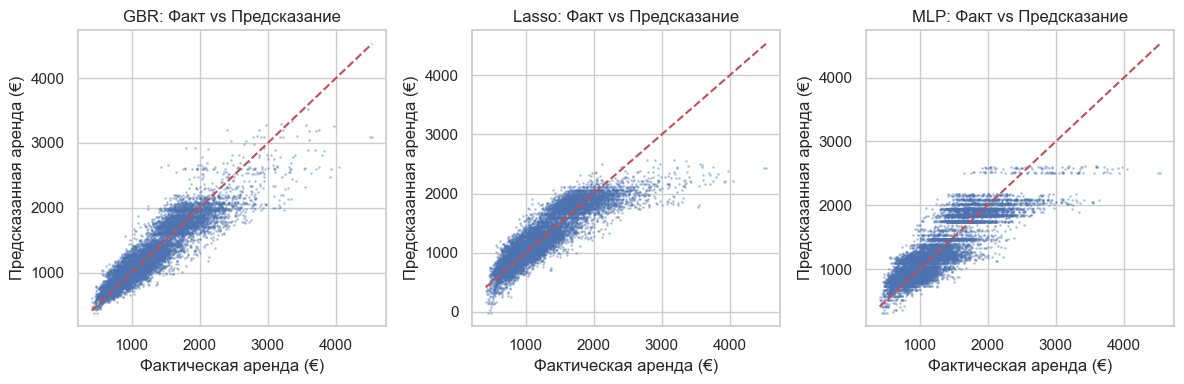

In [45]:
plt.figure(figsize=(12, 4))

for i, (name, pred) in enumerate([('GBR', pred_gbr), ('Lasso', pred_lasso), ('MLP', pred_mlp)], 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, pred, alpha=0.3, s=1)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{name}: Факт vs Предсказание')
    plt.xlabel('Фактическая аренда (€)')
    plt.ylabel('Предсказанная аренда (€)')

plt.tight_layout()
plt.show()

## Вывод

Градиентный бустинг показал наилучшую точность предсказания арендной платы, подтвердив свою эффективность для табличных данных. Лассо-регрессия обеспечила интерпретируемость за счёт отбора значимых признаков. Нейросеть работала стабильно, но уступила по скорости и точности.
Ключевые факторы, влияющие на цену аренды: регион, год,, тип недвижимости и количество спален.